## Contract analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

In [3]:
df_contract_good.head()
df_contract_bad.columns

Index(['token_address', 'chain', 'token_name', 'contract_name', 'verified',
       'owner', 'creator', 'is_hidden_owner', 'is_proxy', 'is_sellable',
       'is_hardcoded_owner', 'has_source_code', 'has_abi', 'total_snippets',
       'honeypot_mechanics_number', 'ownership_manipulation_number',
       'transfer_blocking_number', 'stealth_fee_mechanics_number',
       'liquidity_manipulation_number', 'router_manipulation_number',
       'balance_manipulation_number', 'anti_analysis_features_number',
       'emergency_functions_number'],
      dtype='object')

## How many contracts have renounced their ownership?

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_20308\1986389615.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, val + max(good_counts.values) * 0.01, f'{good_percent[i]:.1f}%', ha='center')


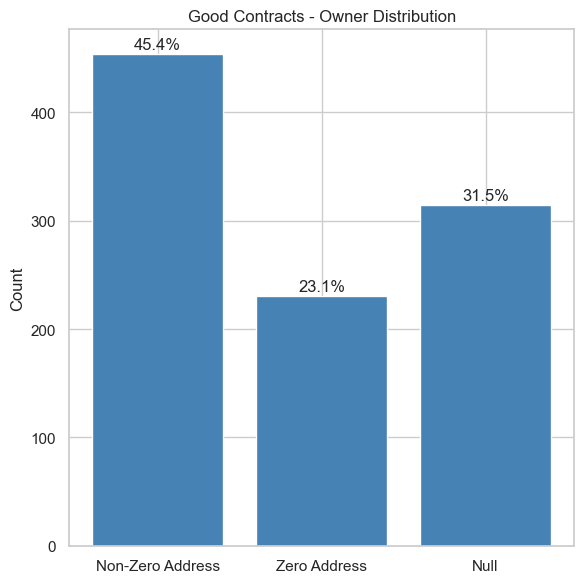

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_20308\1986389615.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, val + max(bad_counts.values) * 0.01, f'{bad_percent[i]:.1f}%', ha='center')


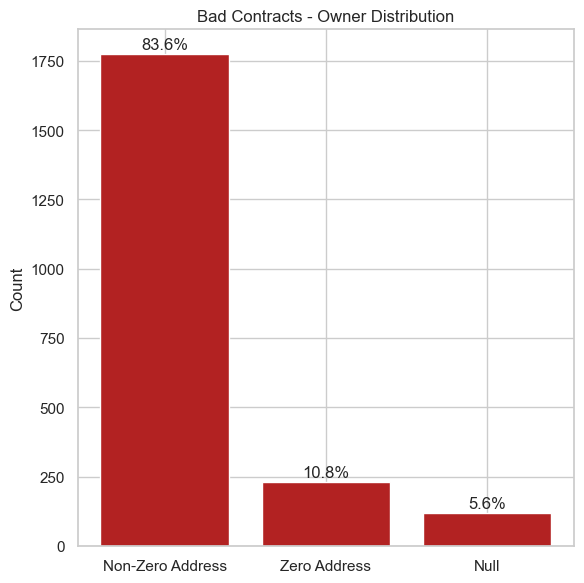

In [12]:
# Define a function to classify owner type
def classify_owner(owner):
    if pd.isna(owner):
        return 'Null'
    elif owner.lower() == '0x0000000000000000000000000000000000000000':
        return 'Zero Address'
    else:
        return 'Non-Zero Address'

# Apply the classification to both DataFrames
df_contract_good['owner_type'] = df_contract_good['owner'].apply(classify_owner)
df_contract_bad['owner_type'] = df_contract_bad['owner'].apply(classify_owner)

# Count owner types
good_counts = df_contract_good['owner_type'].value_counts().reindex(['Non-Zero Address', 'Zero Address', 'Null'], fill_value=0)
bad_counts = df_contract_bad['owner_type'].value_counts().reindex(['Non-Zero Address', 'Zero Address', 'Null'], fill_value=0)

# Calculate percentages
good_percent = good_counts / good_counts.sum() * 100
bad_percent = bad_counts / bad_counts.sum() * 100

# --- First Plot: Good Contracts ---
plt.figure(figsize=(6, 6))
plt.bar(good_counts.index, good_counts.values, color='steelblue')
plt.title('Good Contracts - Owner Distribution')
plt.ylabel('Count')
for i, val in enumerate(good_counts.values):
    plt.text(i, val + max(good_counts.values) * 0.01, f'{good_percent[i]:.1f}%', ha='center')
plt.tight_layout()
plt.show()

# --- Second Plot: Bad Contracts ---
plt.figure(figsize=(6, 6))
plt.bar(bad_counts.index, bad_counts.values, color='firebrick')
plt.title('Bad Contracts - Owner Distribution')
plt.ylabel('Count')
for i, val in enumerate(bad_counts.values):
    plt.text(i, val + max(bad_counts.values) * 0.01, f'{bad_percent[i]:.1f}%', ha='center')
plt.tight_layout()
plt.show()



## How many contracts are verified? Have a hidden owner? proxy? sellable? Have a hardcoded owner? have public source code? abi? 

In [5]:
df_contract_good['is_hidden_owner'].value_counts()

is_hidden_owner
False    685
True     315
Name: count, dtype: int64

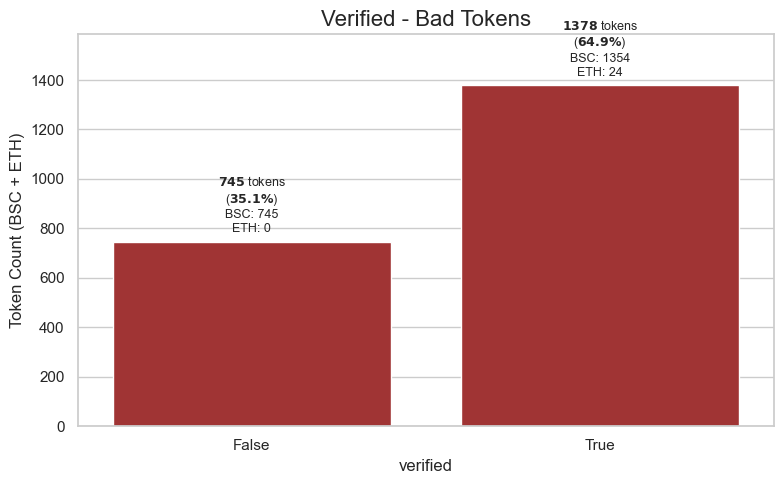

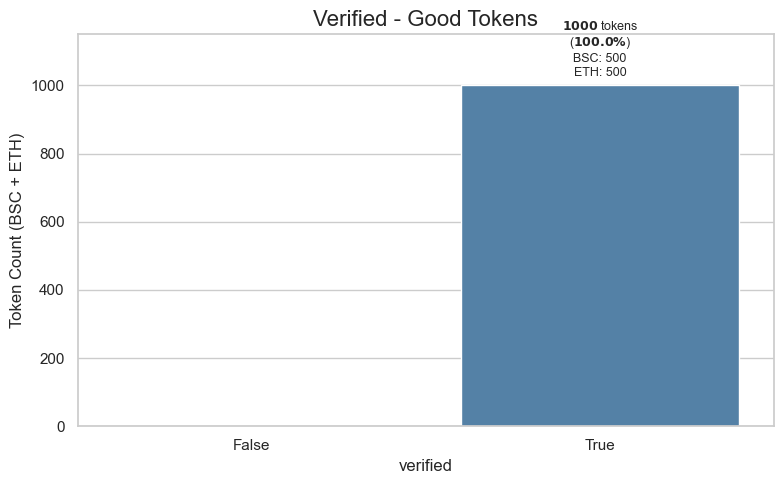

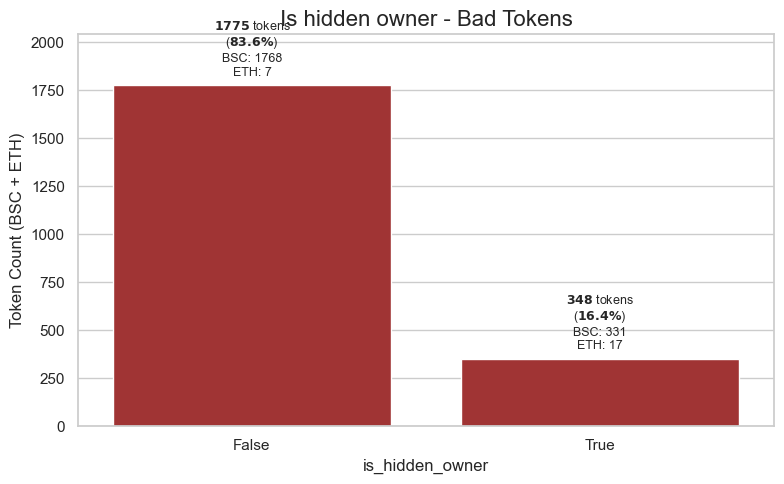

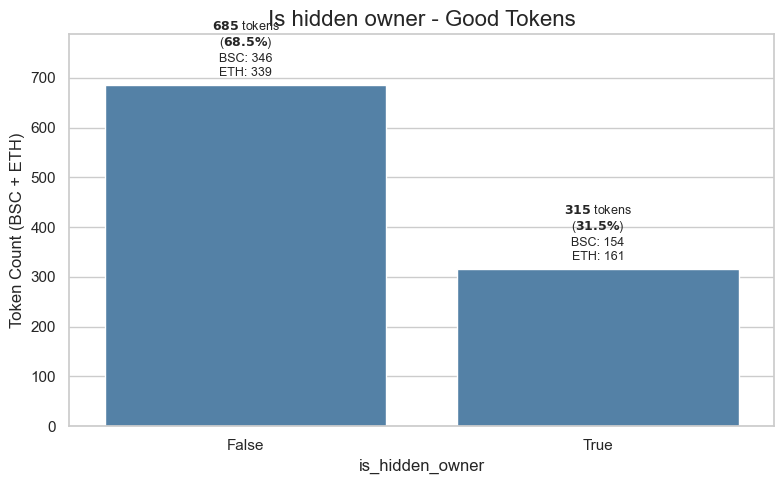

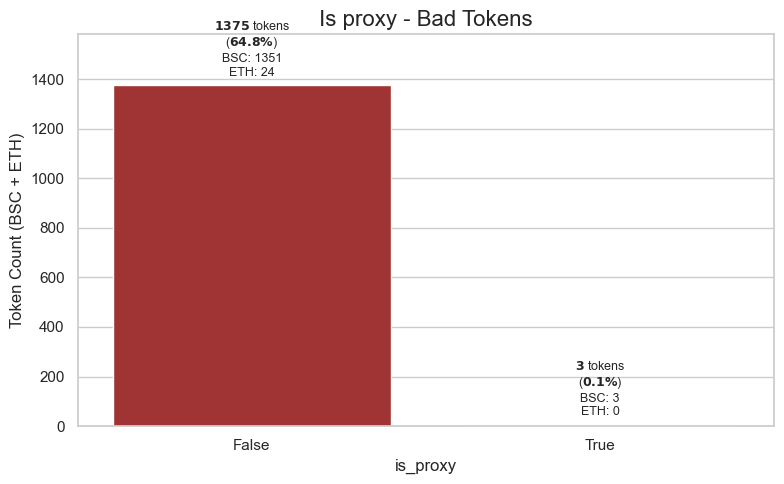

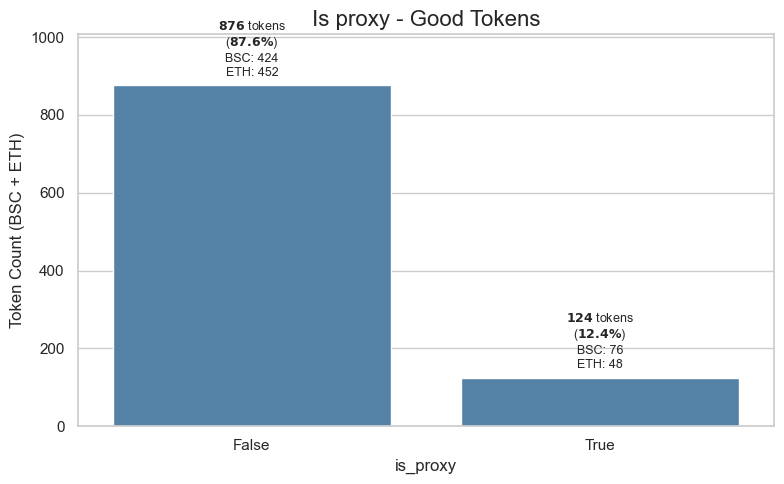

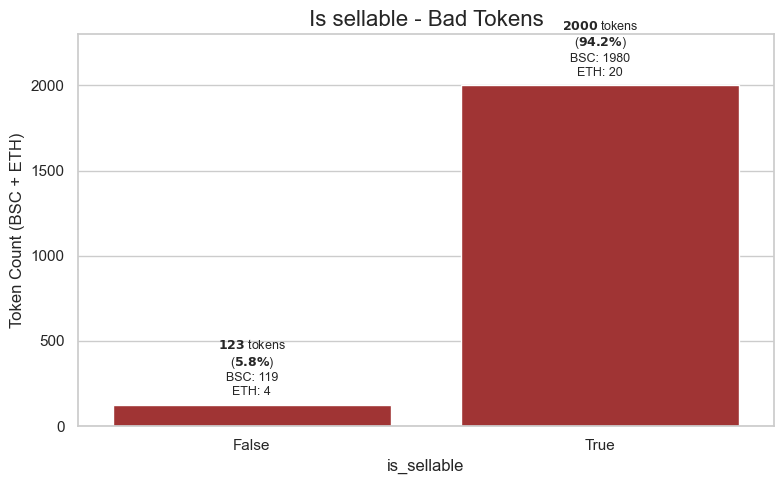

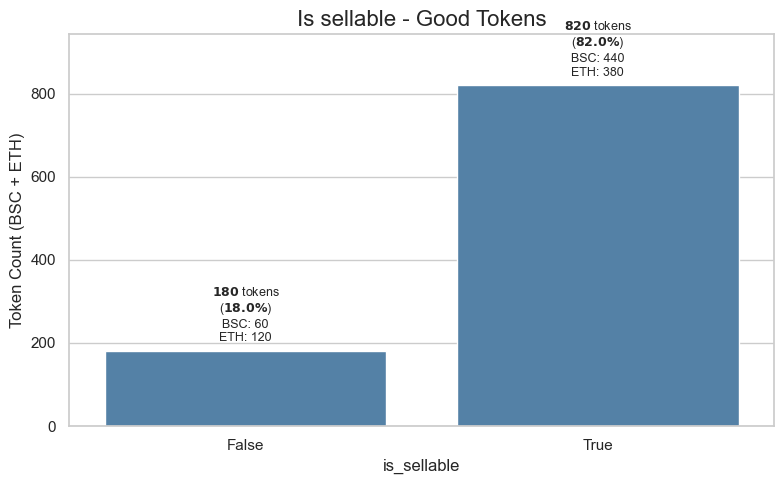

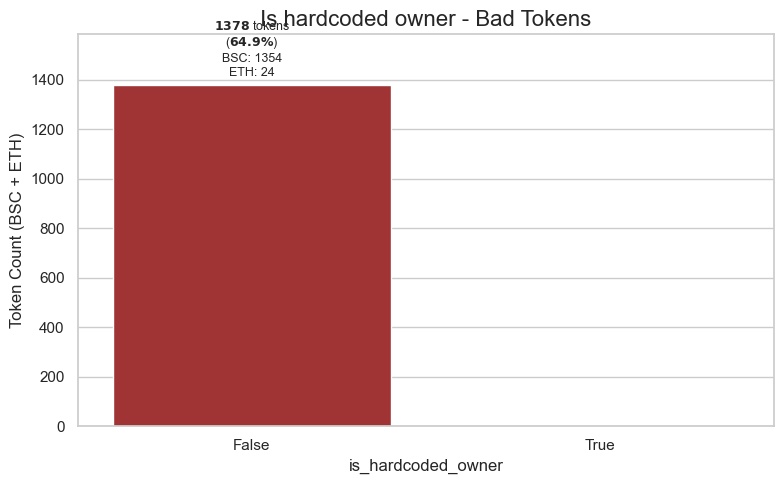

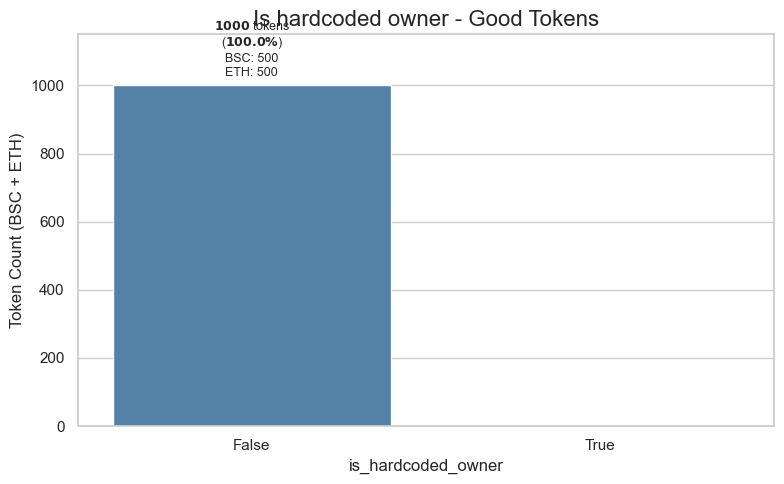

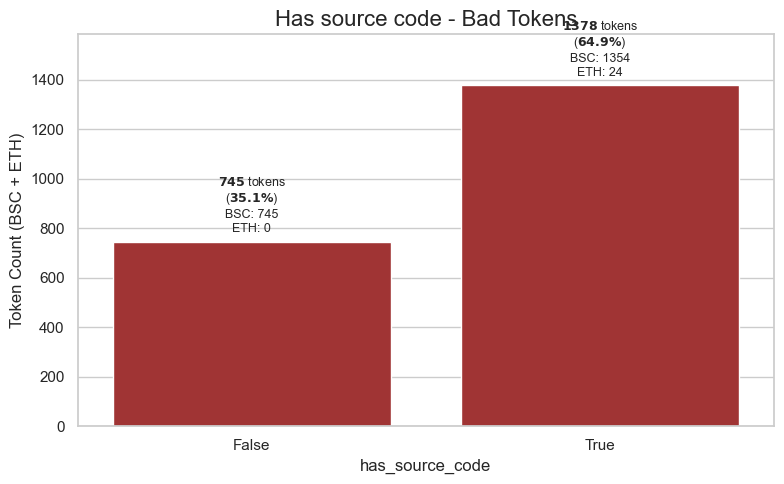

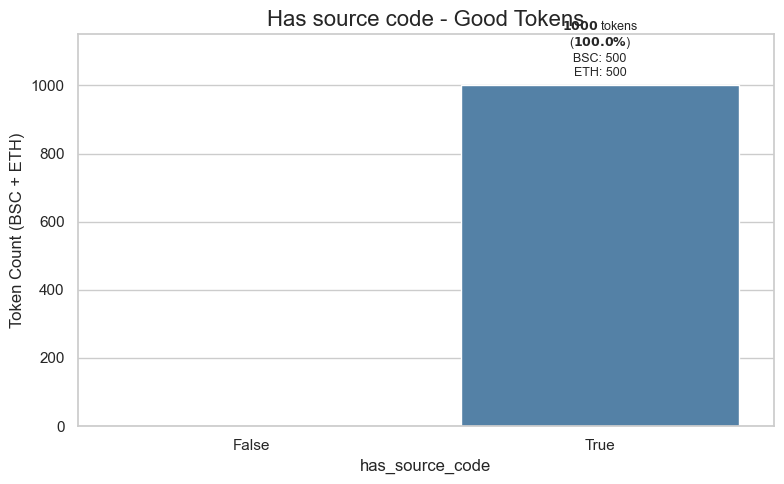

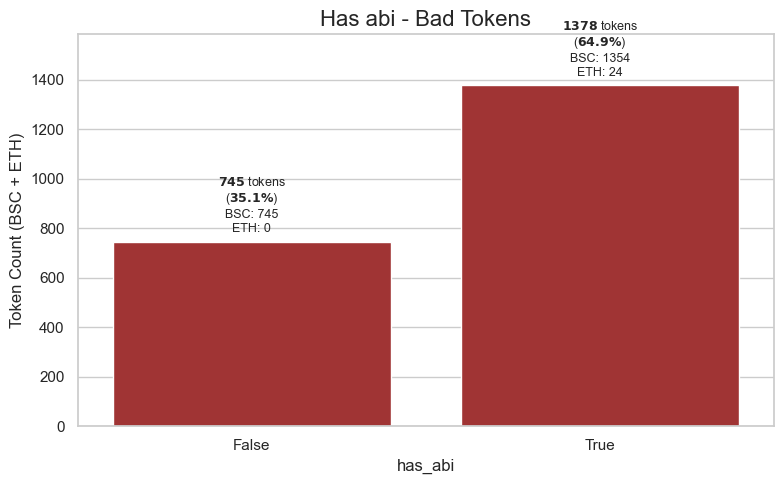

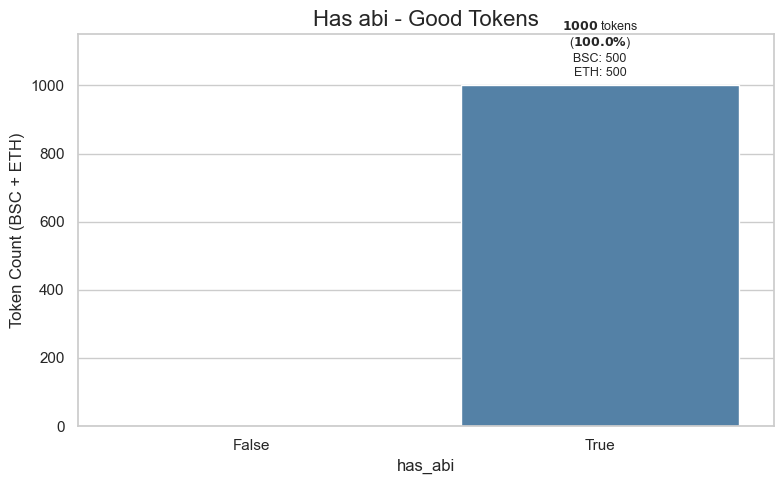

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Load data
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

# Add quality column
df_contract_bad['quality'] = 'bad'
df_contract_good['quality'] = 'good'

# Boolean-like columns
bool_cols = ['verified', 'is_hidden_owner', 'is_proxy', 'is_sellable',
             'is_hardcoded_owner', 'has_source_code', 'has_abi']

# Ensure all expected columns exist
for col in bool_cols:
    for df in [df_contract_bad, df_contract_good]:
        if col not in df.columns:
            df[col] = np.nan

# Convert values to booleans
def to_bool(val):
    val_str = str(val).strip().lower()
    if val_str == 'true':
        return True
    elif val_str == 'false':
        return False
    else:
        return np.nan

for df in [df_contract_bad, df_contract_good]:
    for col in bool_cols:
        df[col] = df[col].apply(to_bool)

# Combine data
df_all = pd.concat([df_contract_bad, df_contract_good], ignore_index=True)
df_all['chain'] = df_all['chain'].str.lower()

# Color map
color_map = {
    'bad': 'firebrick',
    'good': 'steelblue'
}

x_order = [False, True]

# Loop over features and quality
for col in bool_cols:
    for quality in ['bad', 'good']:
        subset = df_all[df_all['quality'] == quality]
        total_tokens = len(subset)

        counts = subset.groupby([col, 'chain']).size().unstack(fill_value=0)
        total_counts = counts.sum(axis=1)
        percentages = total_counts / total_tokens * 100

        plt.figure(figsize=(8, 5))
        plt.title(f"{col.replace('_', ' ').capitalize()} - {quality.capitalize()} Tokens", fontsize=16)

        sns.barplot(
            x=[str(x) for x in x_order],
            y=[total_counts.get(val, 0) for val in x_order],
            order=[str(x) for x in x_order],
            color=color_map[quality]
        )

        plt.xlabel(col)
        plt.ylabel('Token Count (BSC + ETH)')

        y_max = max(total_counts.values) if not total_counts.empty else 1
        plt.ylim(0, y_max + 0.15 * y_max)

        # Add bolded annotations
        for i, bool_val in enumerate(x_order):
            total_count = total_counts.get(bool_val, 0)
            pct = percentages.get(bool_val, 0)

            if total_count == 0:
                continue

            bsc_count = counts.loc[bool_val]['bsc'] if 'bsc' in counts.columns and bool_val in counts.index else 0
            eth_count = counts.loc[bool_val]['eth'] if 'eth' in counts.columns and bool_val in counts.index else 0

            annotation_text = (
                f"$\\bf{{{total_count}}}$ tokens\n"
                f"($\\bf{{{pct:.1f}\\%}}$)\n"
                f"BSC: {bsc_count}\n"
                f"ETH: {eth_count}"
            )

            plt.text(
                i, total_count + y_max * 0.02,
                annotation_text,
                ha='center', va='bottom', fontsize=9
            )

        plt.tight_layout()
        plt.show()


## Snippets analysis

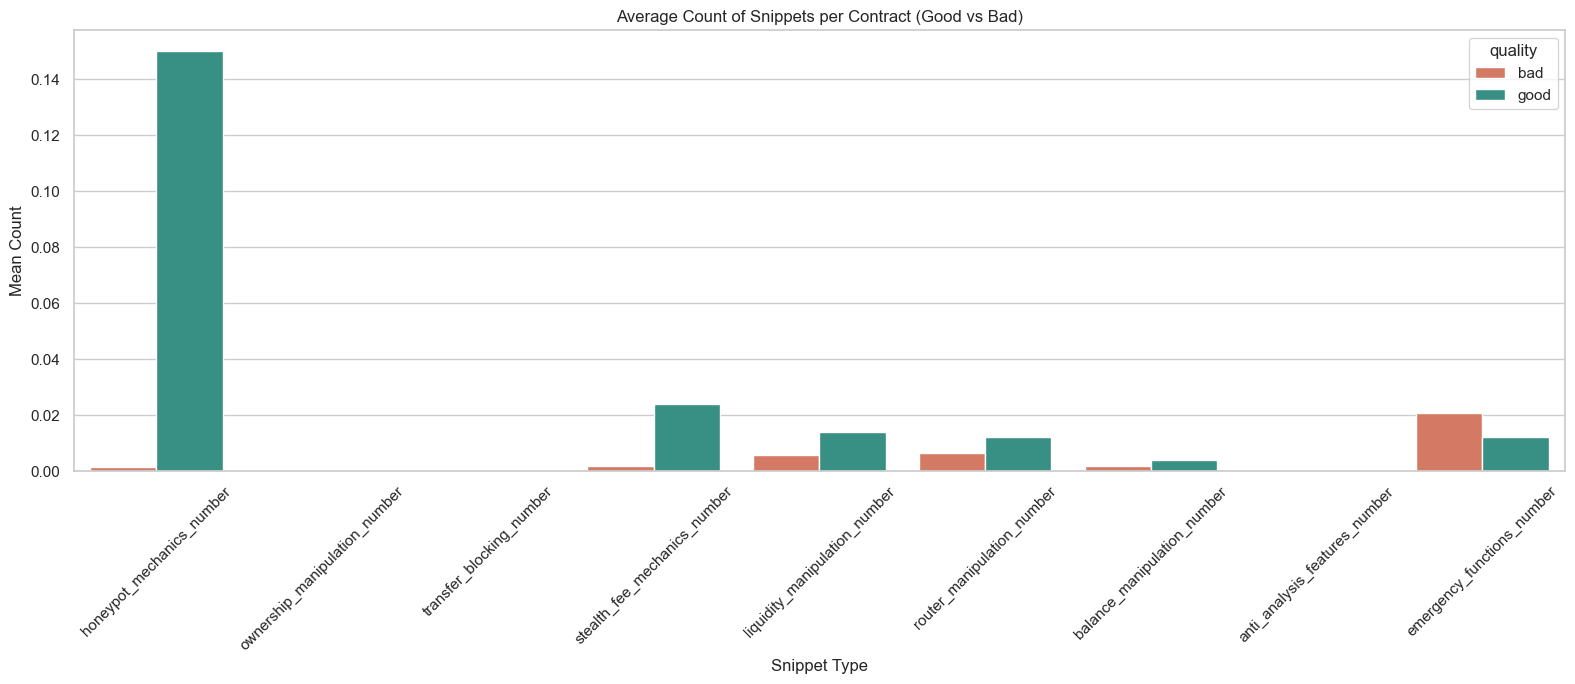

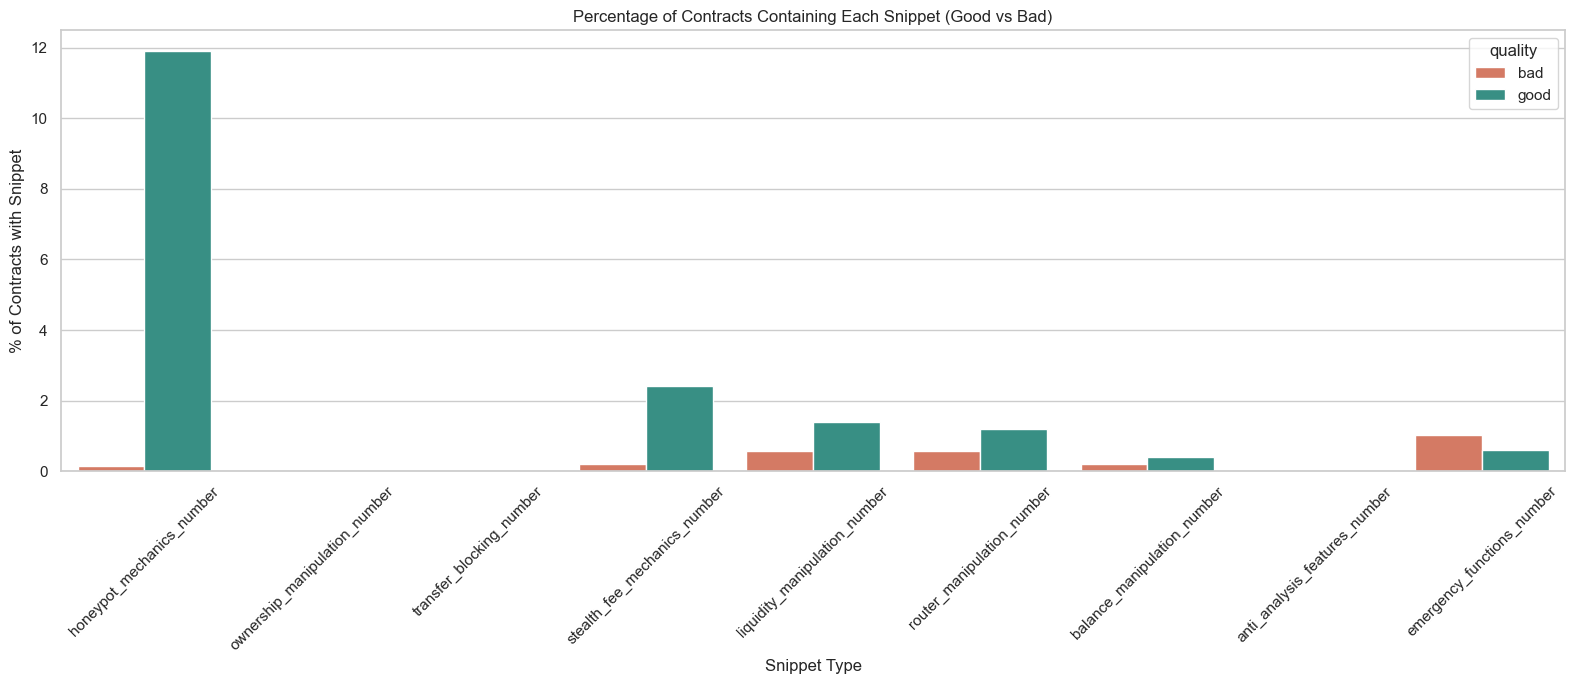

In [7]:
# Load data
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

# Snippet-related columns
snippet_cols = [
    'honeypot_mechanics_number',
    'ownership_manipulation_number',
    'transfer_blocking_number',
    'stealth_fee_mechanics_number',
    'liquidity_manipulation_number',
    'router_manipulation_number',
    'balance_manipulation_number',
    'anti_analysis_features_number',
    'emergency_functions_number'
]

# Set seaborn theme
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# --------------- OPTION A: Mean Count per Contract ----------------

mean_counts = df_all.groupby('quality')[snippet_cols].mean().T
mean_counts = mean_counts.reset_index().rename(columns={'index': 'snippet'})

fig, ax = plt.subplots(figsize=(16, 7))
sns.barplot(
    data=mean_counts.melt(id_vars='snippet', var_name='quality', value_name='mean_count'),
    x='snippet', y='mean_count', hue='quality', ax=ax,
    palette=['#e76f51', '#2a9d8f']
)

ax.set_title("Average Count of Snippets per Contract (Good vs Bad)")
ax.set_ylabel("Mean Count")
ax.set_xlabel("Snippet Type")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# --------------- OPTION B: Presence Rate per Contract ----------------

presence_df = df_all.copy()
for col in snippet_cols:
    presence_df[col] = presence_df[col].fillna(0)
    presence_df[col] = (presence_df[col] > 0).astype(int)

presence_rate = presence_df.groupby('quality')[snippet_cols].mean().T * 100
presence_rate = presence_rate.reset_index().rename(columns={'index': 'snippet'})

fig, ax = plt.subplots(figsize=(16, 7))
sns.barplot(
    data=presence_rate.melt(id_vars='snippet', var_name='quality', value_name='presence_pct'),
    x='snippet', y='presence_pct', hue='quality', ax=ax,
    palette=['#e76f51', '#2a9d8f']
)

ax.set_title("Percentage of Contracts Containing Each Snippet (Good vs Bad)")
ax.set_ylabel("% of Contracts with Snippet")
ax.set_xlabel("Snippet Type")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

